## YAD2K專案說明

[YAD2K](https://github.com/allanzelener/YAD2K) (Yet Another Darknet 2 Keras) 是YOLO_v2演算法實現專案(90%的程式碼使用了Keras、10%的程式碼使用了Tensorflow)。

原始論文: [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) by Joseph Redmond and Ali Farhadi.

### 需求

- [Keras](https://github.com/fchollet/keras)
- [Tensorflow](https://www.tensorflow.org/)
- [Numpy](http://www.numpy.org/)
- [h5py](http://www.h5py.org/) (For Keras model serialization.)
- [Pillow](https://pillow.readthedocs.io/) (For rendering test results.)
- [Python 3](https://www.python.org/)
- [pydot-ng](https://github.com/pydot/pydot-ng) (Optional for plotting model.)

### 安裝

```bash

sudo apt-get install graphviz
git clone https://github.com/allanzelener/yad2k.git
cd yad2k


# pip install
pip install numpy h5py pillow
pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
pip install keras # Possibly older release: conda install keras
pip install pydot-ng
```


### 模型轉換

1. 從[YOLO官方網站](http://pjreddie.com/darknet/yolo/)下載Darknet模型的設置檔與權重檔到專案根目錄。例如:使用MS COCO資料集訓練的預訓練模型
    * 下載[YOLOv2 608x608 設置檔(yolo.cfg)](https://github.com/pjreddie/darknet/blob/master/cfg/yolo.cfg)
    * 下載[YOLOv2 608x608 權重檔(yolo.weights)](https://pjreddie.com/media/files/yolo.weights)
2. 將原本使用Darknet預訓練的YOLO_v2模型透過`yad2k.python`命令稿來轉換為Keras模型
    - 例如: `python yad2k.py yolo.cfg yolo.weights model_data/yolov2_coco_608x608.h5`
  
最後你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
xxxx.ipynb
yad2k.py
yolo.cfg
yolo.weights
├── font/
│   └── FiraMono-Medium.otf
├── images/
│   ├── dog.jpg
│   ├── models/
│   ├── eagle.jpg
│   ├── giraffe.jpg
│   ├── horses.jpg
│   ├── person.jpg
│   └── scream.jpg
├── yad2k/
│   ├── __init__.py
│   ├── models/
│   ├── utils/
│   └── __pycache__/
└── model_data/
    ├── coco_classes.txt
    ├── pascal_classes.txt
    ├── yolov2_coco_608x608.h5
    └── yolov2_coco_608x608_anchors.txt
    
```

### 載入相關函式庫


In [1]:
import warnings
warnings.filterwarnings('ignore') # 暫時隱藏一些Warning訊息

import os
import numpy as np
import platform
import tensorflow
import keras
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

from PIL import Image
from yad2k.models.keras_yolo import yolo_eval, yolo_head
import cv2
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as display

%matplotlib inline

print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

Platform: Linux-4.13.0-32-generic-x86_64-with-Ubuntu-16.04-xenial
Tensorflow version: 1.5.0-rc0
Keras version: 2.1.3


Using TensorFlow backend.


### 設定相關基本設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 模型相關資料的目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model_data")

# 圖像類別定義文件路徑，預設為"coco_classes.txt"
CLASSES_FILE_PATH = os.path.join(MODEL_PATH, "coco_classes.txt")

# 設定模型權重檔案
MODEL_FILENAME = "yolov2_coco_608x608.h5"

# 設定模型權重檔案路徑
MODEL_FILE_PATH = os.path.join(MODEL_PATH, MODEL_FILENAME)

# 設定錨點文件檔案
ANCHORS_FILENAME = "yolov2_coco_608x608_anchors.txt"

# 錨點文件的路徑，預設為"yolo_anchors.txt" (x1,y1,x2,y2,x3,y3,x4,y4,x5,y5)
ANCHORS_FILE_PATH = os.path.join(MODEL_PATH, ANCHORS_FILENAME)

# 模型輸入的圖像大小與顏色頻道數
IMAGE_HEIGHT = 608
IMAGE_WEIGHT = 608
IMAGE_CHANNELS = 3

# 設定邊界框過濾的閥值(confidence score)
SCORE_THRESHOLD = 0.3

# IOU(Intersection over Union)的閥值
IOU_THRESHOLD = 0.5

# 驗證用的圖像目錄，預設為"images/"
TEST_PATH = os.path.join(ROOT_DIR, "images")

# 處理結果的圖像目錄，預設為"images/out"
OUTPUT_PATH = os.path.join(ROOT_DIR, "images_out")

In [3]:
# 檢查"OUTPUT_PATH"的目錄是否存在
if not os.path.exists(OUTPUT_PATH):
    print('Creating output path {}'.format(OUTPUT_PATH))
    os.mkdir(OUTPUT_PATH)

In [4]:
# 取得Tensorflow的session物件
sess = K.get_session()

In [5]:
# 取得物件的類別名稱(要看模型是用那一種資料集來進行訓練)
with open(CLASSES_FILE_PATH) as f:
    class_names = f.readlines() # 一行是一個圖像類別

# 把這些圖像類別放到一個列表中
class_names = [c.strip() for c in class_names]

In [6]:
# 取得圖像的預設錨點 (x1,y1,x2,y2,x3,y3,x4,y4,x5,y5)
with open(ANCHORS_FILE_PATH) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2) # 錨點是 (x, y) 一組

### 載入網絡結構模型

In [7]:
# 載入由Darknet轉換的YOLOv2模型
yolo_model = load_model(MODEL_FILE_PATH)

In [8]:
# 打印模型結構
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

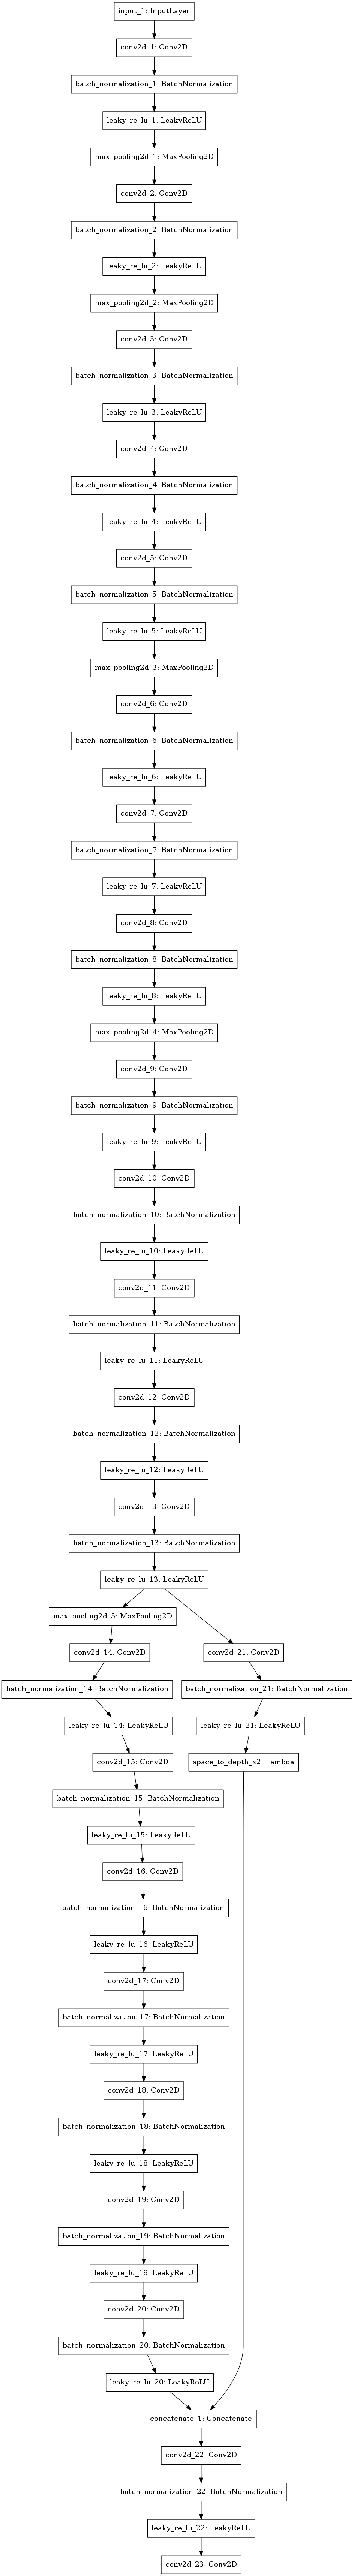

In [9]:
# 產生網絡拓撲圖
plot_model(yolo_model, to_file='yolov2_model.png')

# 顯示網絡拓撲圖
display.Image('yolov2_model.png')

In [10]:
num_classes = len(class_names)
num_anchors = len(anchors)

# 取出Yolo v2模型的最後一層 -> "conv2d_23"的輸出為(19, 19, 425)
model_output_channels = yolo_model.layers[-1].output_shape[-1]

# 最後features map的為度是19x19x425 (為什是425)
# 主要是因為Yolo v2把整個圖像分成19x19個小區塊(cell)
# 而每個小區塊(cell)要predict"num_anhcors(5)"個邊界框(bounding boxs)
# 因此(19, 19, 425)中的前2個維度就是定義每一個小區塊(cell), 而"425"則代表著:
#     - x, y, width, height (定義邊界框的座標) -> 4個浮點數
#     - 邊界框裡包含物體的信心分數(confidence score) -> 1個浮點數
#     - 每一種類別的機率(num_classes) -> 80個浮點數 (MS Coco的資料集有80種圖像類別)
#     - ((4+1) + 80) * 5 = 425

# 驗證 model, anchors 與 classes 是符合的
if model_output_channels != (num_anchors * (num_classes + 5)):
    print("Mismach between model and given anchor and class sizes")
    
print('model[{}], anchors[{}] and classes[{}] loaded'.format(MODEL_FILENAME, num_anchors, num_classes))

model[yolov2_coco_608x608.h5], anchors[5] and classes[80] loaded


In [11]:
# 檢查模型的Input圖像大小
model_images_size = yolo_model.layers[0].input_shape[1:3]  # (h, w, channel)

is_fixes_size = model_images_size != (None, None)  # 如果 h, w都是"None"代表任何圖像的size都可以
print("Flag: is_fixes_size[{}]".format(is_fixes_size))

print("Model input size: ", model_images_size)  #打印出來看看

Flag: is_fixes_size[True]
Model input size:  (608, 608)


In [12]:
# 將最後的圖層特徵轉換為邊界框的相對參數
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

input_image_shape = K.placeholder(shape=(2, ))

# 使用YOLO模型評估給定的輸入批次和相關的閥值，返回過濾後的邊界框
boxes, scores, classes = yolo_eval(yolo_outputs,
                                  input_image_shape,
                                  score_threshold=SCORE_THRESHOLD,
                                  iou_threshold=IOU_THRESHOLD)

print("boxes: ", boxes)
print("scores: ", scores)
print("classes: ", classes)

boxes:  Tensor("Gather:0", shape=(?, 4), dtype=float32)
scores:  Tensor("Gather_1:0", shape=(?,), dtype=float32)
classes:  Tensor("Gather_2:0", shape=(?,), dtype=int64)


## 圖像的物體偵測

先看一下原始要用來測試的圖像

In [13]:
# 指定要用來進行物體偵測的圖像
TEST_IMG = 'dog.jpg'

# 驗證用的圖像目錄，預設為"images/"
TEST_IMG_PATH = os.path.join(TEST_PATH, TEST_IMG)

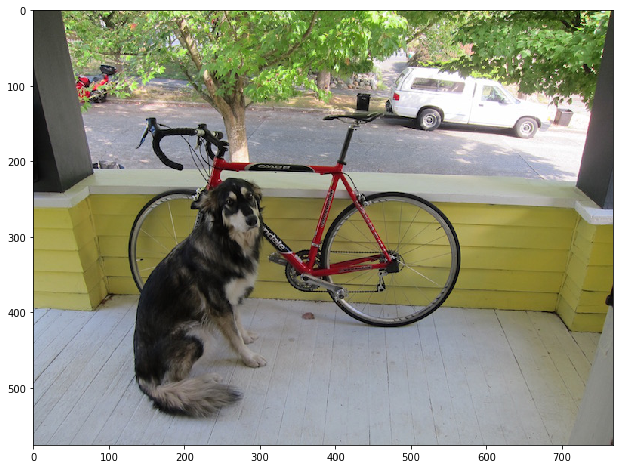

In [14]:
# 將原始的圖像秀出來
plt.figure(figsize=(15,8))
img = plt.imread(TEST_IMG_PATH)
plt.imshow(img)

## 始用YOLO V2 來偵測物體
YOLO的模型主要的任務有兩個:
1. 偵測邊界框(Bounding boxes)
2. 對邊界框裡的物體進行辨識(Object recognition)

由於我們使用了Darknet使用MS COCO圖像集所預訓練的YOLOv2 608x608模型。這個預訓練的模型預期它的圖像輸人有以下的前處理:
1. 圖像資料的張量形狀(tensor shape)為(608, 608, 3)也就是圖像RGB三色頻且大小為608x608
2. 圖像的張量需要進行歸一化的處理(除以255)以及資料型別為浮點數32

### 資料前處理

In [15]:
# 載入圖像
image = Image.open(TEST_IMG_PATH)

print("Before image resize: ", np.array(image, dtype='float32').shape)

# 修改數入圖像大小來符合模型的要求
resized_image = image.resize(tuple(reversed(model_images_size)), Image.BICUBIC)
image_data = np.array(resized_image, dtype='float32')  # (img_height, img_width, img_channels)

print("After image resize: ", image_data.shape)

# 進行圖像歸一處理
image_data /= 255.

print("Before expand dim: ", image_data.shape)

image_data = np.expand_dims(image_data, 0)  # 變成 (batch size, img_height, img_width, img_channels)

print("After expand dim: ", image_data.shape)

Before image resize:  (576, 768, 3)
After image resize:  (608, 608, 3)
Before expand dim:  (608, 608, 3)
After expand dim:  (1, 608, 608, 3)


### 資料的推論預測

由於YAD2K的YOLO的實作混合了Keras與Tensorflow, 因此在預測的階段需要使用Tensorflow的Session物件。

由於一個圖像中可能有多個邊界框, 因此在YOLO的模型在進行圖像的輸入之後會有以下的輸出:
1. 邊界框列表(boxes)-列表中的每個資料結構包括了4個浮點數, 分別代表左上角的(x1,y1)及右下角的(x2,y2)
2. 邊界框信心分數列表(confidence scores)-列表中的每個資料結構包括了1個浮點數, 代表每個邊界框有物體在框內的信心分數
3. 邊界框物體類別機率列表(object category probabilities)-列表中的每個資料結構包括了1個整數, 它代表機率值最大的那一個物體類別的索引

In [16]:
# 取得YOLOv2模型偵測受的結果
out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes],
                                             feed_dict={
                                                 yolo_model.input: image_data,
                                                 input_image_shape: [image.size[1], image.size[0]],
                                                 K.learning_phase(): 0
                                             })

print("out_boxes.shape: ", out_boxes.shape, out_boxes.dtype)
print("out_score.shape: ", out_scores.shape, out_boxes.dtype)
print("out_classes.shape", out_classes.shape, out_classes.dtype)

out_boxes.shape:  (3, 4) float32
out_score.shape:  (3,) float32
out_classes.shape (3,) int64


### 圖像偵測結果

將找到的物體類別、信心分數與邊界框秀到圖像上

dog 0.78 (137, 214) (323, 540)
truck 0.80 (462, 82) (694, 168)
bicycle 0.84 (81, 112) (554, 469)


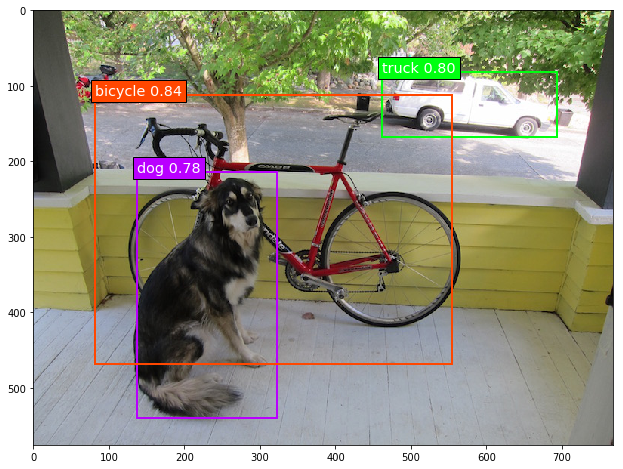

In [17]:
# 為不同的bounding box 產生不同的顏色
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(15, 8))
plt.imshow(image)

current_axis = plt.gca()

# 迭代每個找到的物體類別
for i, c in reversed(list(enumerate(out_classes))):    
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    
    label = '{} {:.2f}'.format(predicted_class, score)
    
    # "邊界框"的座標
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    
    # 打印圖像類別, 邊界框的左上角及右下角的座標
    print(label, (left, top), (right, bottom))

    color = colors[c]

    # 畫"邊界框"
    current_axis.add_patch(plt.Rectangle((left, top), right-left, bottom-top, color=color, fill=False, linewidth=2))  

    # 把文字標籤的資訊放到圖像上
    current_axis.text(left, top, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [18]:
# 關閉Tensorflow的Session
sess.close()

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:

* 因為開源所以大家都可以站在別人的肩膀上快速累積快速學習
* 很多看起來複雜的演算法, 當了解它的核心設計思想之後, 就會覺得簡單很多
* 很多不同深度學習框架所訓練出來的模型只要清楚它的架構後也可以快速的轉換到其它的框架上去使用
* 做為一個工程師也可以用整合性的角度來思考每種技術的應用與整合

參考:
* [YOLO官網](https://pjreddie.com/darknet/yolo/)
* [llSourcell/YOLO_Object_Detection](https://github.com/llSourcell/YOLO_Object_Detection)
* [allanzelener/YAD2K](https://github.com/allanzelener/YAD2K)